In [2]:
import os
import random
import re
import sys

import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist, squareform

# import umap
import pytorch_lightning as pl
import scanpy as sc
from anndata import AnnData

import matplotlib.pyplot as plt
from matplotlib import cm, colors
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import seaborn as sns
import torch
import torch.nn as nn
import textwrap

import gseapy as gp

pl.seed_everything(32)

sys.path.append("/data/danai/scripts/LIVI/")
from src.analysis._utils import annotate_factor_GSEA, assign_factor_to_known_pathways, select_important_genes_for_factor_IQR
from src.analysis.plotting import make_gp_dotplot, cell_state_factors_heatmap, plot_gene_loadings_for_factor, plot_U_factor_corr, plot_GxC_similarity, plot_donor_similarity

Seed set to 32
/data/danai/miniforge3/envs/LIVIenv_py311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Seed set to 32


In [3]:
adata = sc.read_h5ad("/data/danai/Data/OneK1K/LogNorm_counts_across_celltypes_DCRM_protein-coding_Azimuth_only-immune-cells_HVG-HEX-10K.h5ad")
adata

AnnData object with n_obs × n_vars = 1172790 × 14212
    obs: 'orig_ident', 'nCount_RNA', 'nFeature_RNA', 'pool', 'individual', 'percent_mt', 'latent', 'nCount_SCT', 'nFeature_SCT', 'cell_type', 'cell_label', 'sex', 'age', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_MITO', 'log1p_total_counts_MITO', 'pct_counts_MITO', 'total_counts_RIBO', 'log1p_total_counts_RIBO', 'pct_counts_RIBO', 'total_counts_ERCC', 'log1p_total_counts_ERCC', 'pct_counts_ERCC', 'n_genes', 'Norm_factors', 'major_celltype', 'predicted_celltype_l0', 'predicted_celltype_l1', 'predicted_celltype_l2', 'original_celltype', 'new_predicted_celltype_l2', 'new_predicted_celltype_l0', 'new_predicted_celltype_l1'
    var: 'GeneSymbol', 'features', 'MITO', 'RIBO', 'ERCC', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'downregulated_NK', '

In [4]:
adata.obs.cell_label.nunique()

14

In [5]:
gene_anno = pd.read_csv("/data/danai/Data/OneK1K/OneK1K_HVG-HEX-10K_geneIDs_Biomart.txt", sep="\t", index_col=0)
gene_anno.rename(columns={"Gene stable ID":"feature_id", 
                         "Gene name":"gene_name",
                         "Chromosome/scaffold name":"gene_chromosome", 
                         "Gene start (bp)":"gene_start", 
                         "Gene end (bp)":"gene_end"},
                inplace=True)
gene_anno

,gene_start,gene_chromosome,gene_end,gene_name
Gene stable ID,,,,
ENSG00000000419,49551404,20,49575092,DPM1
ENSG00000000457,169818772,1,169863408,SCYL3
ENSG00000000460,169631245,1,169823221,C1orf112
ENSG00000000938,27938575,1,27961788,FGR
ENSG00000000971,196621008,1,196716634,CFH
...,...,...,...,...
ENSG00000273269,47293080,2,47403650,RP11-761B3.1
ENSG00000273274,32930670,1,32962287,ZBTB8B
ENSG00000273294,33987279,5,34124633,RP11-1084J3.4


In [6]:
adata.var.GeneSymbol = adata.var.GeneSymbol.str.strip()
adata.var = adata.var.merge(gene_anno.filter(["gene_chromosome", "gene_start", "gene_end"]), right_index=True, left_index=True)
adata.var

,GeneSymbol,features,MITO,RIBO,ERCC,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,...,downregulated_CD8T,upregulated_B,downregulated_B,upregulated_Mono,downregulated_Mono,upregulated_DC,downregulated_DC,gene_chromosome,gene_start,gene_end
ENSG00000257019,OR13C2,OR13C2,False,False,False,3,0.000002,0.000002,99.999764,3.0,...,False,False,False,False,False,False,False,9,107366924,107367951
ENSG00000166987,MBD6,MBD6,False,False,False,34604,0.027840,0.027459,97.280605,35426.0,...,True,True,True,True,False,False,True,12,57914493,57923931
ENSG00000170624,SGCD,SGCD,False,False,False,1844,0.001487,0.001486,99.855087,1892.0,...,False,True,True,True,True,False,True,5,155297354,156194799
ENSG00000140519,RHCG,RHCG,False,False,False,2,0.000002,0.000002,99.999843,2.0,...,False,False,False,False,False,False,False,15,89998680,90039844
ENSG00000117115,PADI2,PADI2,False,False,False,2728,0.002279,0.002276,99.785617,2900.0,...,True,True,True,True,False,True,True,1,17393256,17445948
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000185811,IKZF1,IKZF1,False,False,False,338926,0.332737,0.287235,73.365114,423404.0,...,True,True,True,True,True,False,True,7,50343720,50472799
ENSG00000234465,PINLYP,PINLYP,False,False,False,3098,0.002490,0.002487,99.756540,3168.0,...,False,False,False,False,False,False,False,19,44080952,44088116
ENSG00000170615,SLC26A5,SLC26A5,False,False,False,685,0.000540,0.000540,99.946168,687.0,...,False,False,False,False,False,False,False,7,102993177,103086624
ENSG00000151778,SERP2,SERP2,False,False,False,2513,0.002013,0.002011,99.802513,2561.0,...,True,True,True,True,True,False,True,13,44947801,44971850


In [7]:
# COLORS FROM THE ORIGINAL PUBLICATION
cell_label_colors = {
    "CD4 SOX4": "#D6C1DE", # SOX4+ CD4 T cells
    "CD4 NC": "#882E72", # CD4 naive T cells
    "CD4 ET": "#B178A6", # CD4 effectorT  cells
    "CD8 NC": "#5289C7", # CD8 naive T cells
    "CD8 S100B": "#7BAFDE", # S100B+ CD8 cells
    "CD8 ET": "#1965B0", # CD8 effector cells 
    "NK": "#4EB265",
    "NK R": "#90C987", # NK recruiting cells
    "B IN": "#F6C141",
    "B Mem": "#F7EE55",
    "Mono C": "#F1932D", # classical monocytes
    "Mono NC": "#E8601C", # non-classical monocytes
    "DC": "#DC050C",
    "Plasma": "#CAE0AB",
}

# matching colros for major (L1) celltype
major_celltype_colors = {
    "CD4T": "darkmagenta",
    "CD8T": "steelblue", 
    "NK": "mediumseagreen",
    "B": "gold",
    "Mono": "orange",
    "DC": "#DC050C",
    "Plasma": "#CAE0AB",
}

In [8]:
adata.uns["cell_label_colors"] = [cell_label_colors[ct] for ct in adata.obs.cell_label.cat.categories]

In [9]:
results_dir = "/data/danai/Data/OneK1K/LIVI2_testing_results/"
model = "2024-12-05_10-20_LIVIcis-cell-state_zdim15_700-gxc_5-persistent_60-0-warm-up_no-adversary_Gseed200_hvg-hex-10K_larger-encoder_best"
model_results_dir = os.path.join(results_dir, model)
os.path.isdir(model_results_dir)

True

## Cell-state factors

In [10]:
zbase = pd.read_csv(os.path.join(model_results_dir, f"{model}_cell-state_latent.tsv"),
                    sep="\t", index_col=0)

In [11]:
base_decoder = pd.read_csv(os.path.join(model_results_dir,f"{model}_cell-state_decoder.tsv"),
                           sep="\t", index_col=0)

In [12]:
zbase_softmax = nn.Softmax(dim=1)(torch.from_numpy(zbase.to_numpy())).numpy()

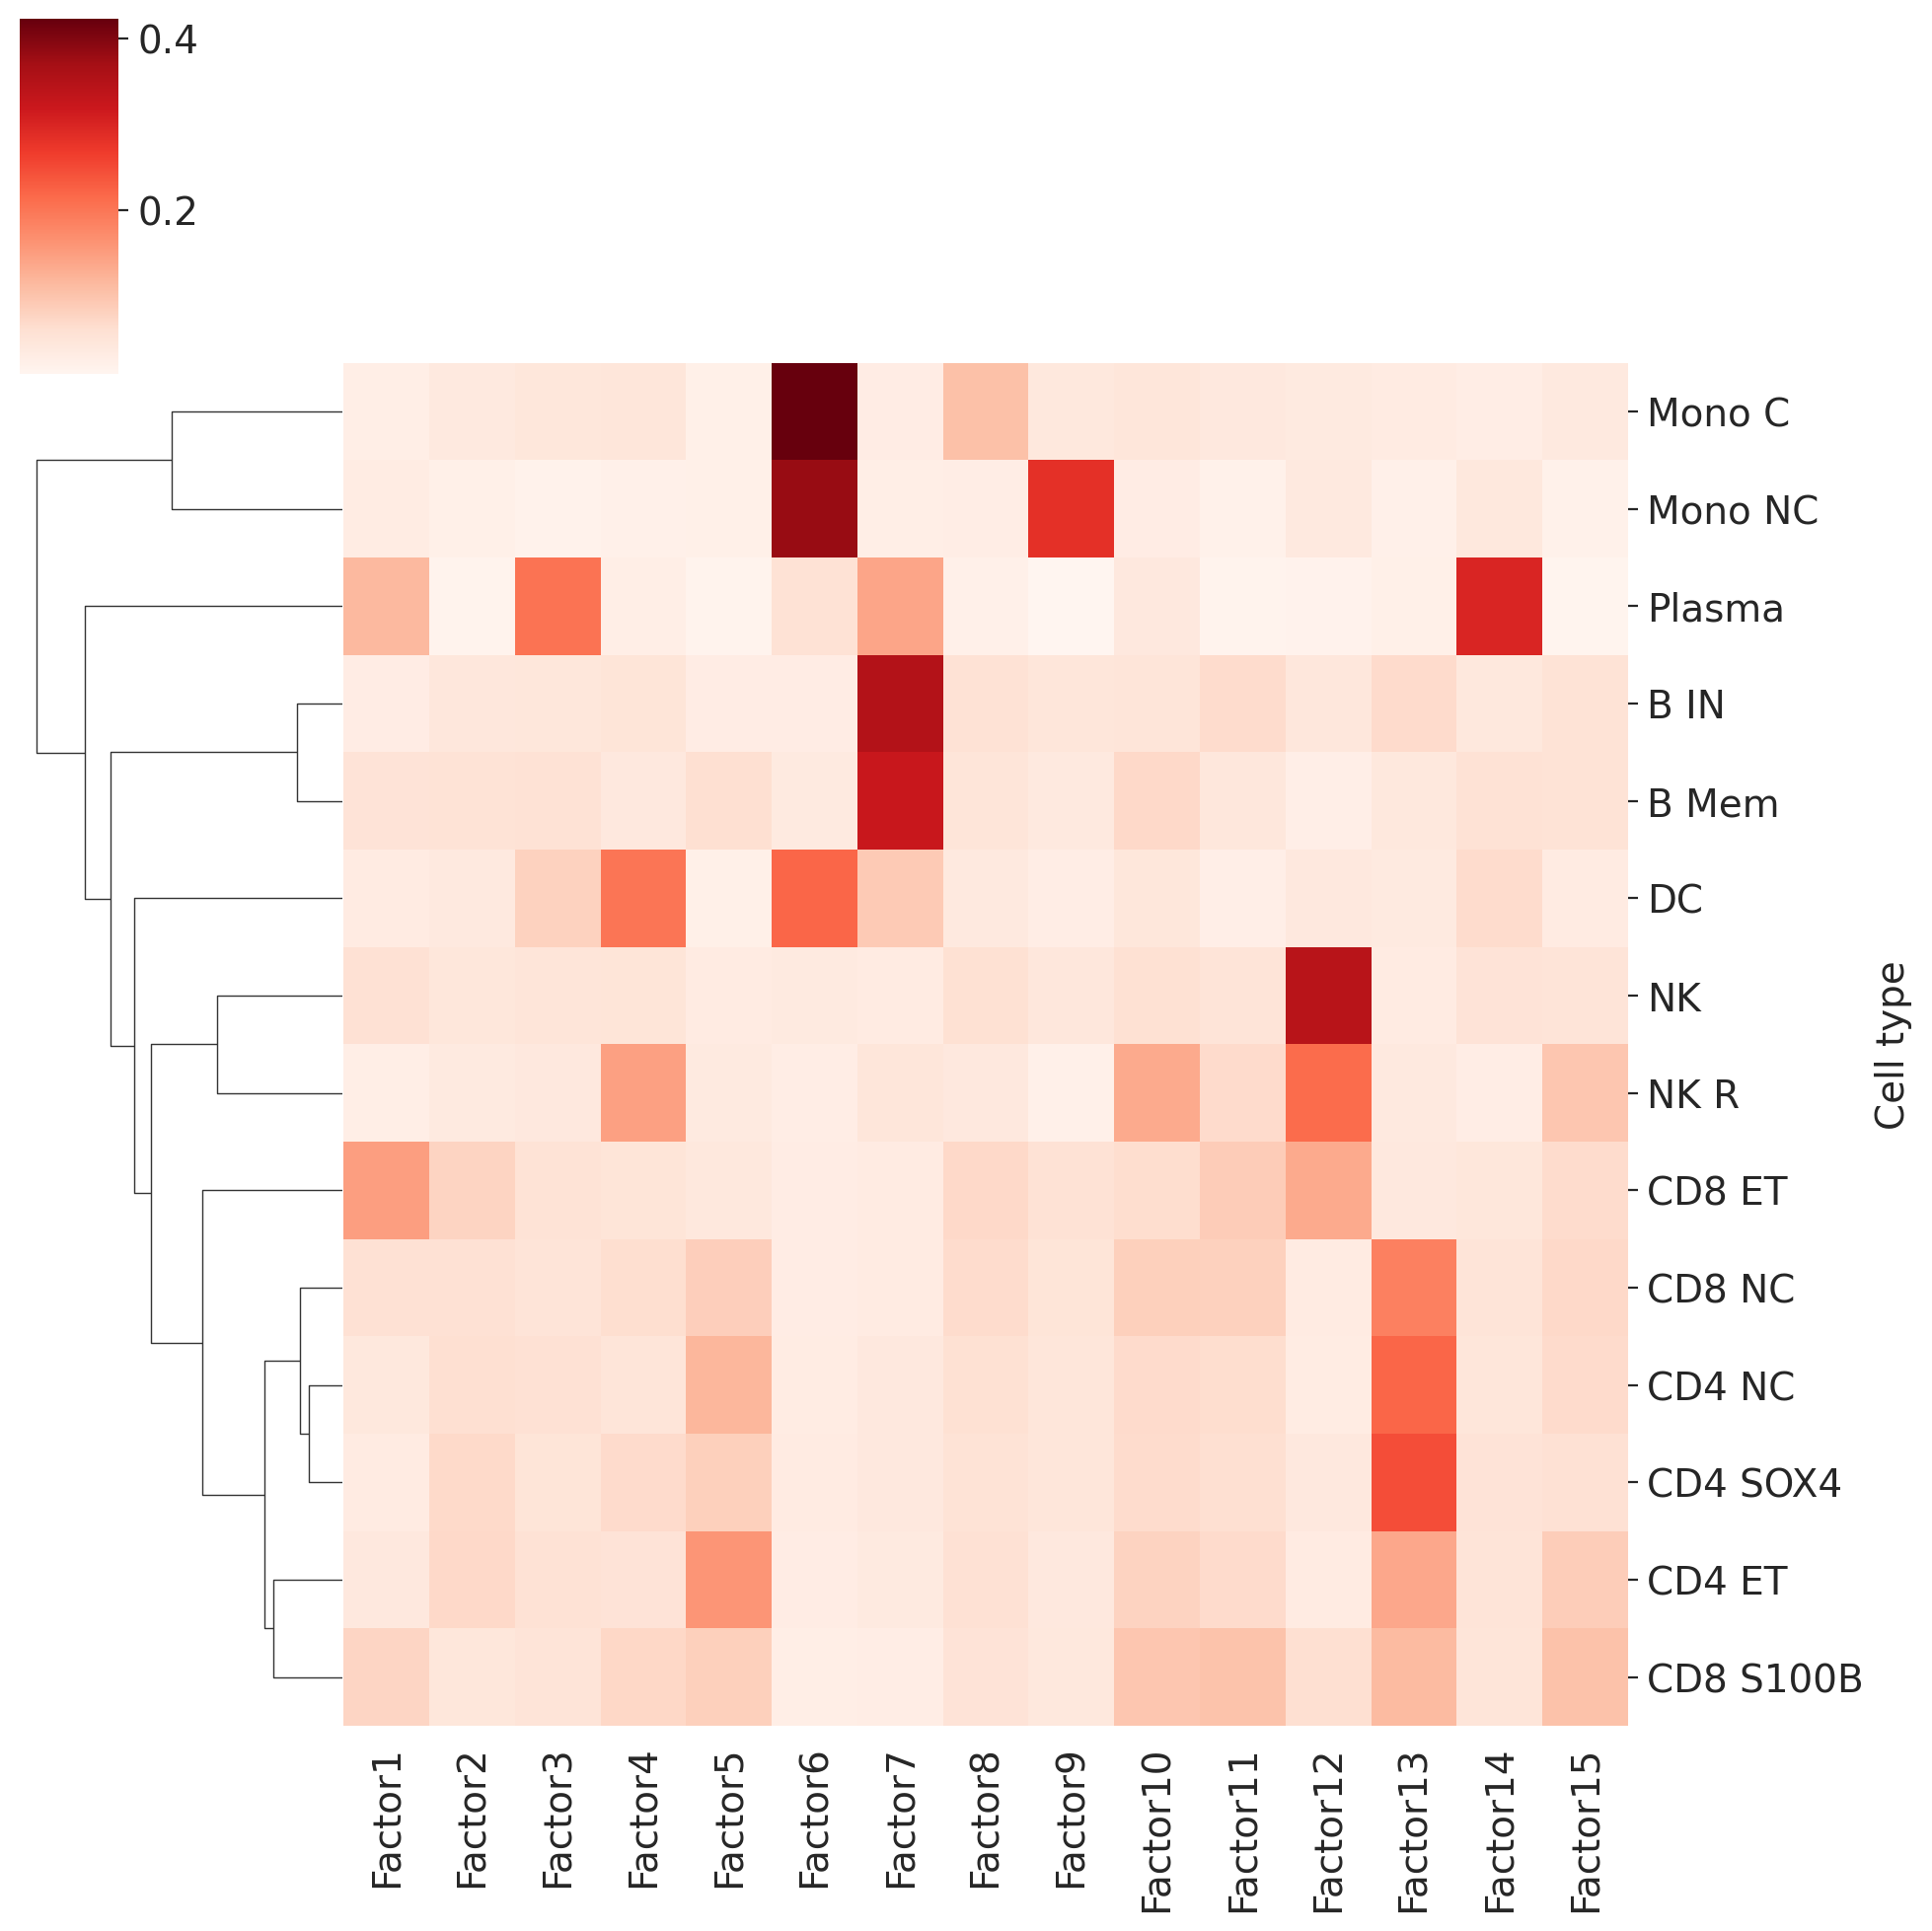

In [13]:
celltypes_factors = cell_state_factors_heatmap(cell_state_factors=zbase_softmax , # zbase.to_numpy(), 
                                               cell_idx=range(adata.obs.shape[0]),
                                               cell_metadata=adata.obs,
                                               celltype_column="cell_label", 
                                               color_map="Reds",
                                               row_cluster=True,
                                               column_cluster=False, 
                                               z_score=None,
                                               savefig=os.path.join(model_results_dir, "Figures", f"{model}_Softmax.png"),
                                               return_df=True)

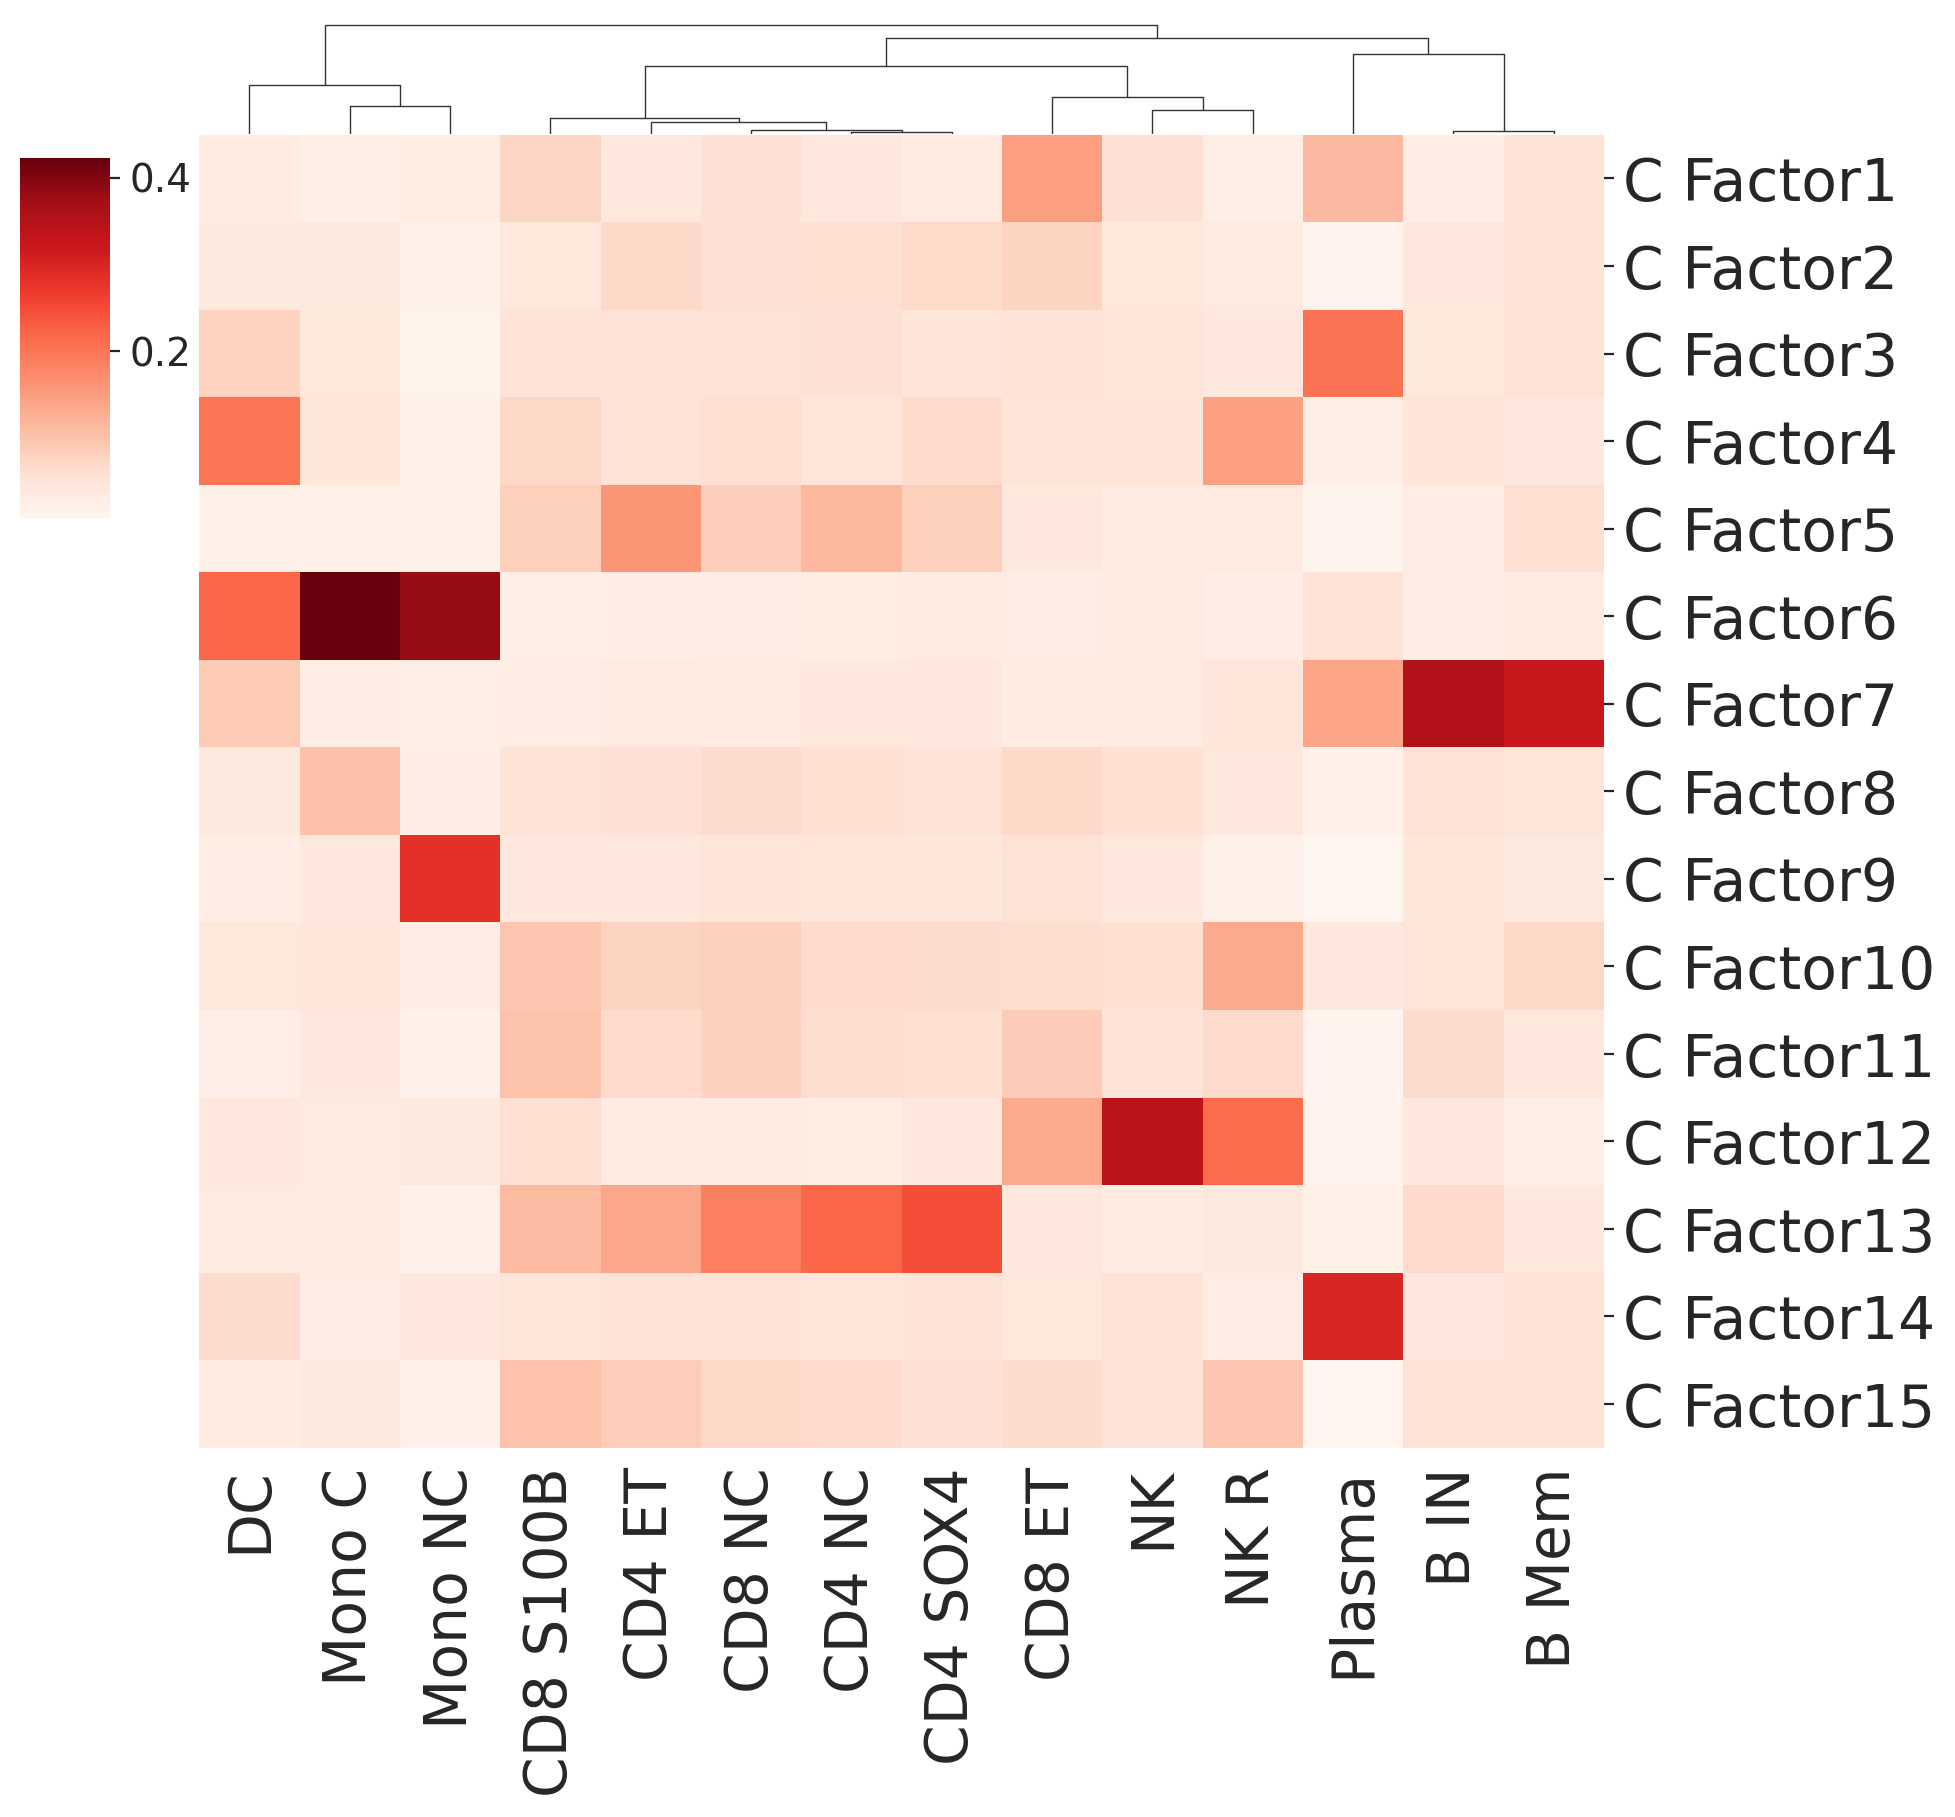

In [16]:
clm = sns.clustermap(
    celltypes_factors.T,
    row_cluster=False,
    col_cluster=True, 
    dendrogram_ratio=(0.08),
    cbar_pos=(-0.008, 0.7, 0.05, 0.2), # (1.07, 0.19, 0.05, 0.2), 
    z_score=None,
    metric="cosine",
    cmap="Reds",
    center=None, # 0.0 use it only with RdBu_r cmap
    figsize=(9, 9),
    annot_kws={"size": 20},
    rasterized=True,
)

clm.ax_heatmap.set_xlabel("")
clm.ax_heatmap.set_xticklabels(
    clm.ax_heatmap.get_xticklabels(),
    fontsize=21
)
clm.ax_heatmap.set_yticklabels(
    ["C "+lb.get_text() for lb in clm.ax_heatmap.get_yticklabels()],
    fontsize=21
)

clm.savefig(
    os.path.join(model_results_dir, "Figures", f"{model}_Heatmap_Cell-state-factors_cosine-distance_Transposed_Reds-cmap.eps"),
    dpi=400,
    transparent=True,
    bbox_inches="tight",
)


In [489]:
umap_base = pd.read_csv(os.path.join(model_results_dir, f"{model}_cell-state_latent_UMAP.tsv"), sep="\t", index_col=0)
umap_base

,UMAP1,UMAP2
barcode,,
AAACCTGAGAATGTTG-1,11.114731,-0.032576
AAACCTGAGAGAACAG-1,7.623209,6.374956
AAACCTGAGCATGGCA-1,10.390140,-4.561501
AAACCTGAGTATTGGA-1,10.588090,4.197966
AAACCTGAGTGTCCCG-1,9.551620,4.313600
...,...,...
TTTGTCATCCGCTGTT-9,11.031625,12.578114
TTTGTCATCCGTTGTC-9,11.443354,-2.383449
TTTGTCATCGCCGTGA-9,11.493034,-4.194935


In [490]:
adata.obsm["X_umap"] = umap_base.loc[adata.obs.index].to_numpy()

In [89]:
sc.settings._vector_friendly = True

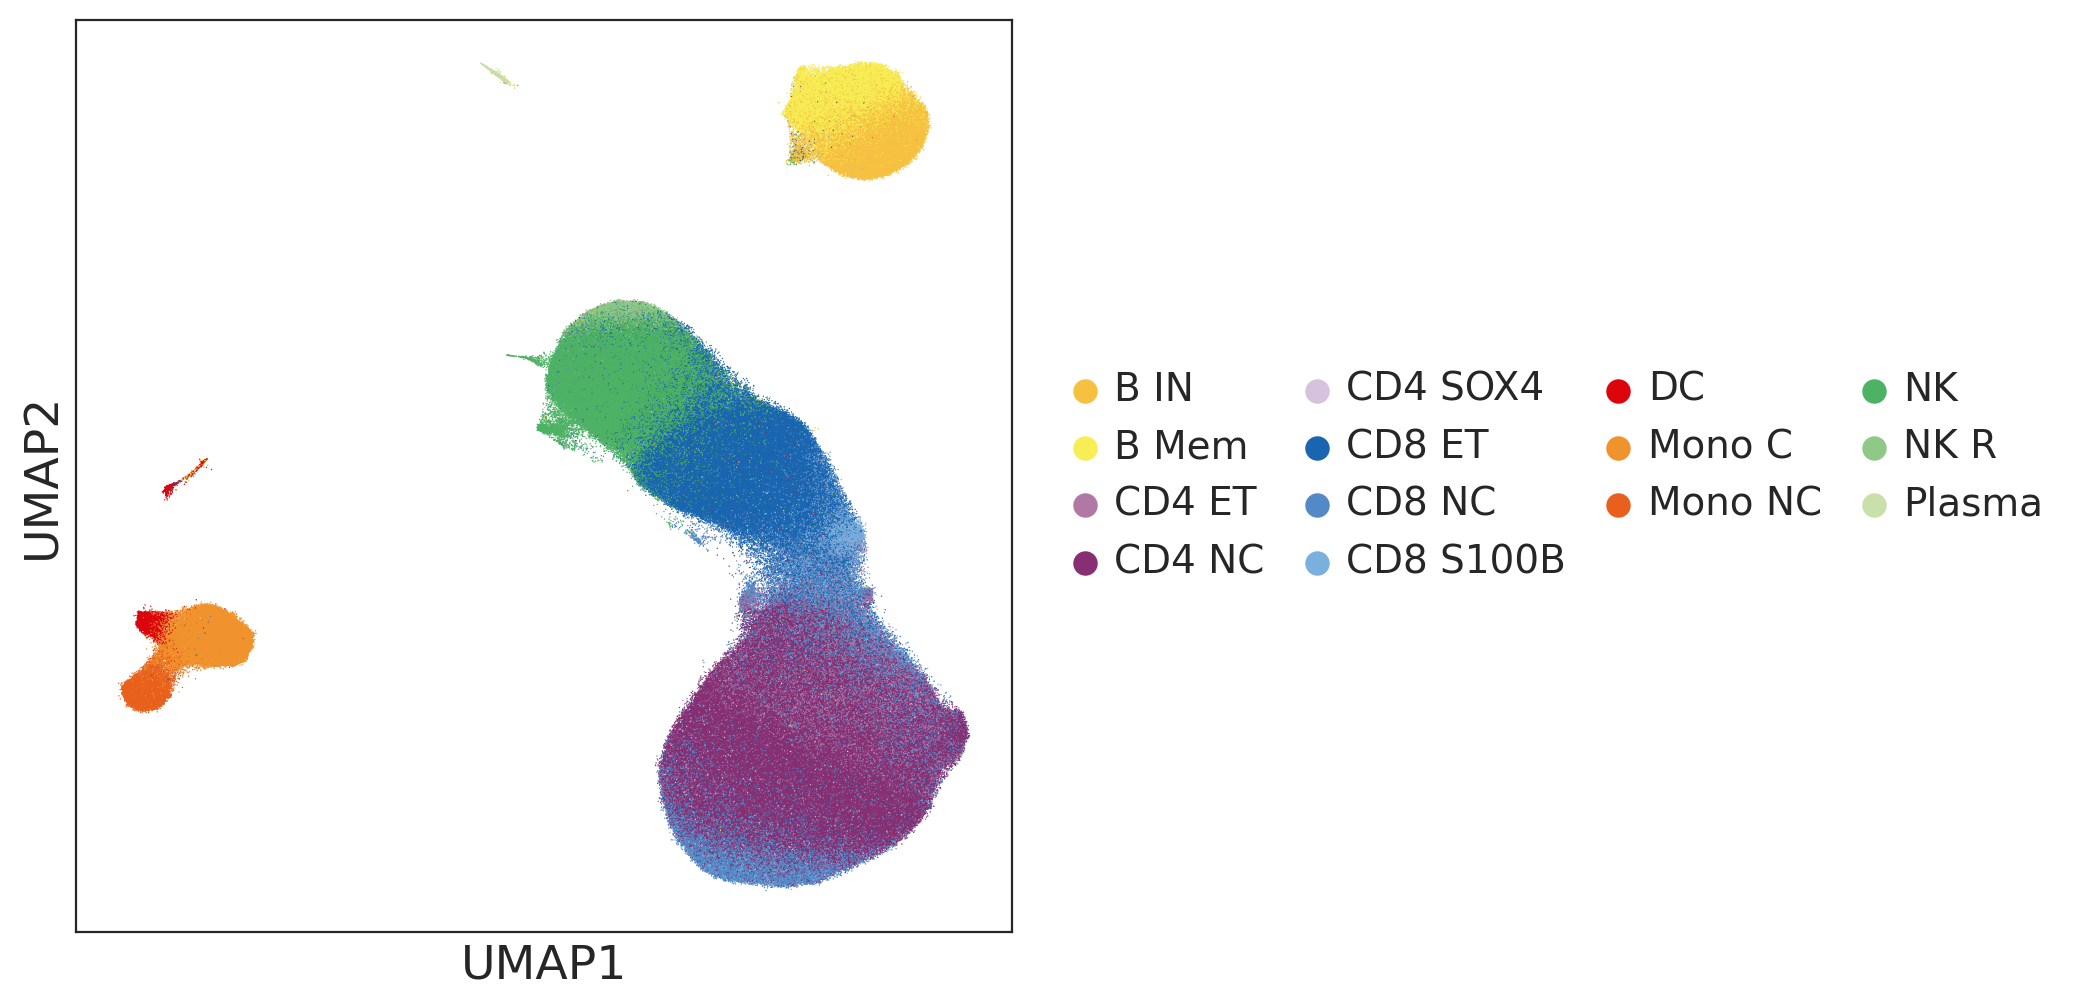

In [90]:
fig, axs = plt.subplots(figsize=(6,6))
sc.pl.umap(adata, color="cell_label", size=1, title="", ax=axs, show=False)
axs.set_xlabel("UMAP1", fontsize=17)
axs.set_ylabel("UMAP2", fontsize=17)
axs.legend(
    title="",
    loc="center left",
    bbox_to_anchor=(1.03, 0.5),
    frameon=False,
    fontsize=14,
    title_fontsize=16,
    ncol=4,
    markerscale=1.3,
    handletextpad=0.5,
    columnspacing=1.1,
)
plt.savefig(os.path.join(model_results_dir, "Figures", f"{model}_UMAP_Cell-state_NEW.eps"), 
            bbox_inches="tight", transparent=True, dpi=500)
plt.savefig(os.path.join(model_results_dir, "Figures", f"{model}_UMAP_Cell-state_NEW.png"), 
            bbox_inches="tight", transparent=True, dpi=500)

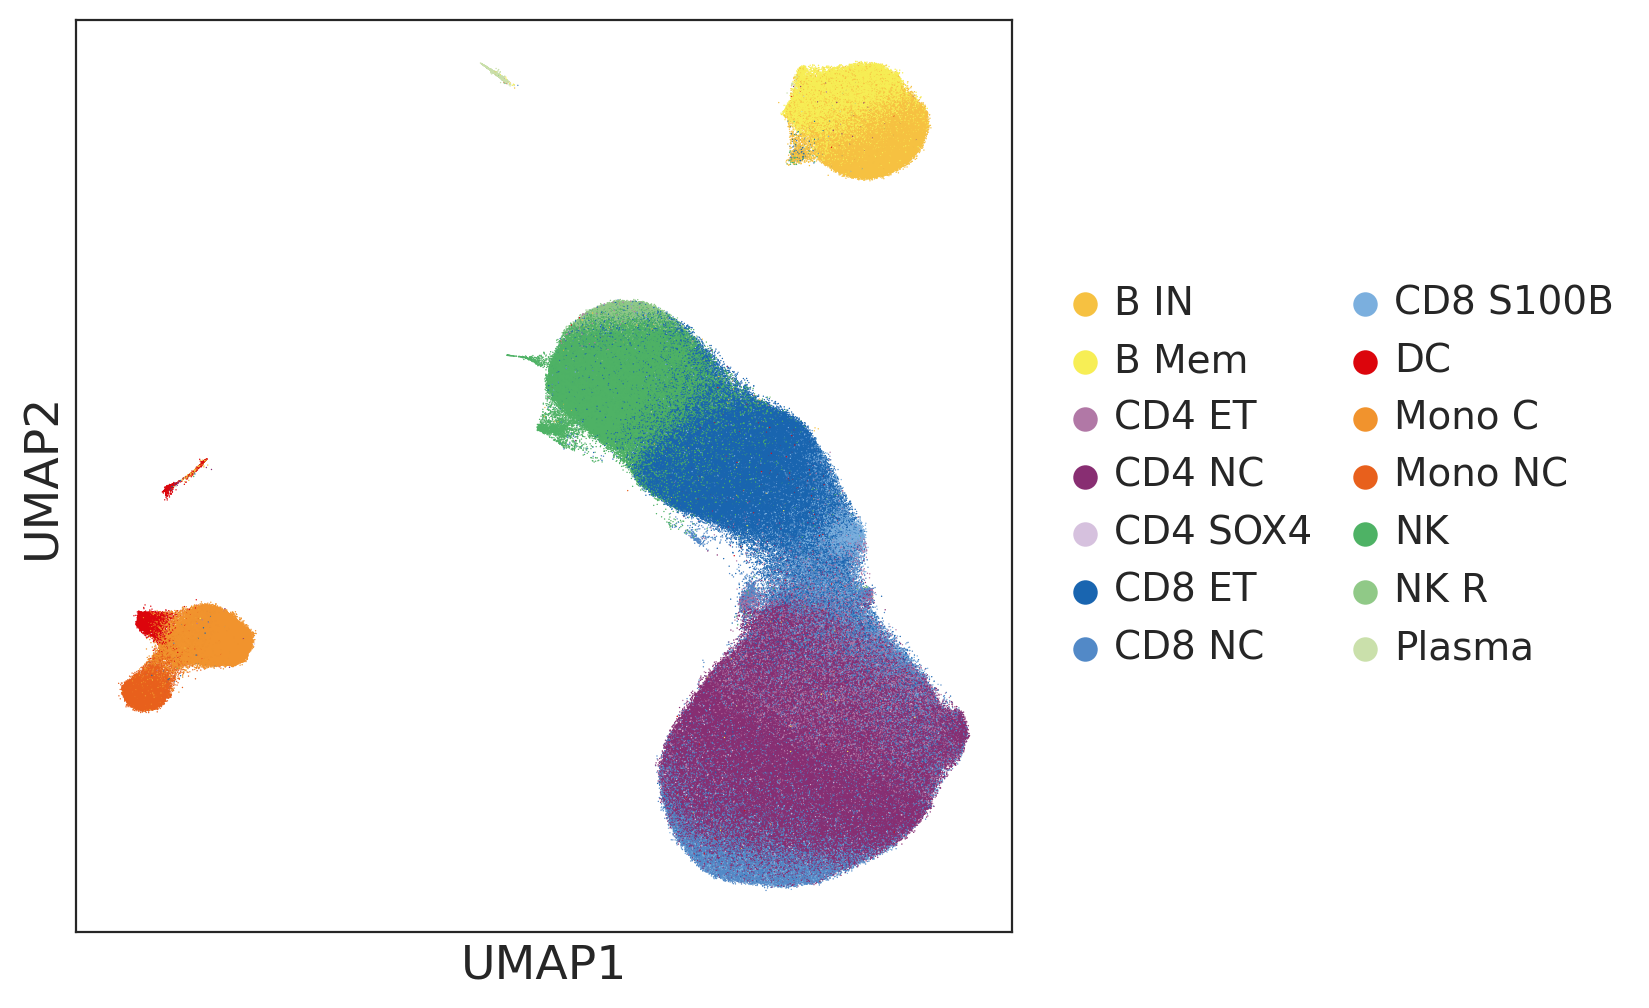

In [91]:
fig, axs = plt.subplots(figsize=(6,6))
sc.pl.umap(adata, color="cell_label", size=1, title="", ax=axs, show=False)
axs.set_xlabel("UMAP1", fontsize=17)
axs.set_ylabel("UMAP2", fontsize=17)
axs.legend(
    title="",
    loc="center left",
    bbox_to_anchor=(1.03, 0.5),
    frameon=False,
    fontsize=14,
    title_fontsize=16,
    ncol=2,
    markerscale=1.3,
    handletextpad=0.5,
    columnspacing=1.1,
)
plt.savefig(os.path.join(model_results_dir, "Figures", f"{model}_UMAP_Cell-state_NEW_2col-legend.eps"), 
            bbox_inches="tight", transparent=True, dpi=500)
plt.savefig(os.path.join(model_results_dir, "Figures", f"{model}_UMAP_Cell-state_NEW_2col-legend.png"), 
            bbox_inches="tight", transparent=True, dpi=500)

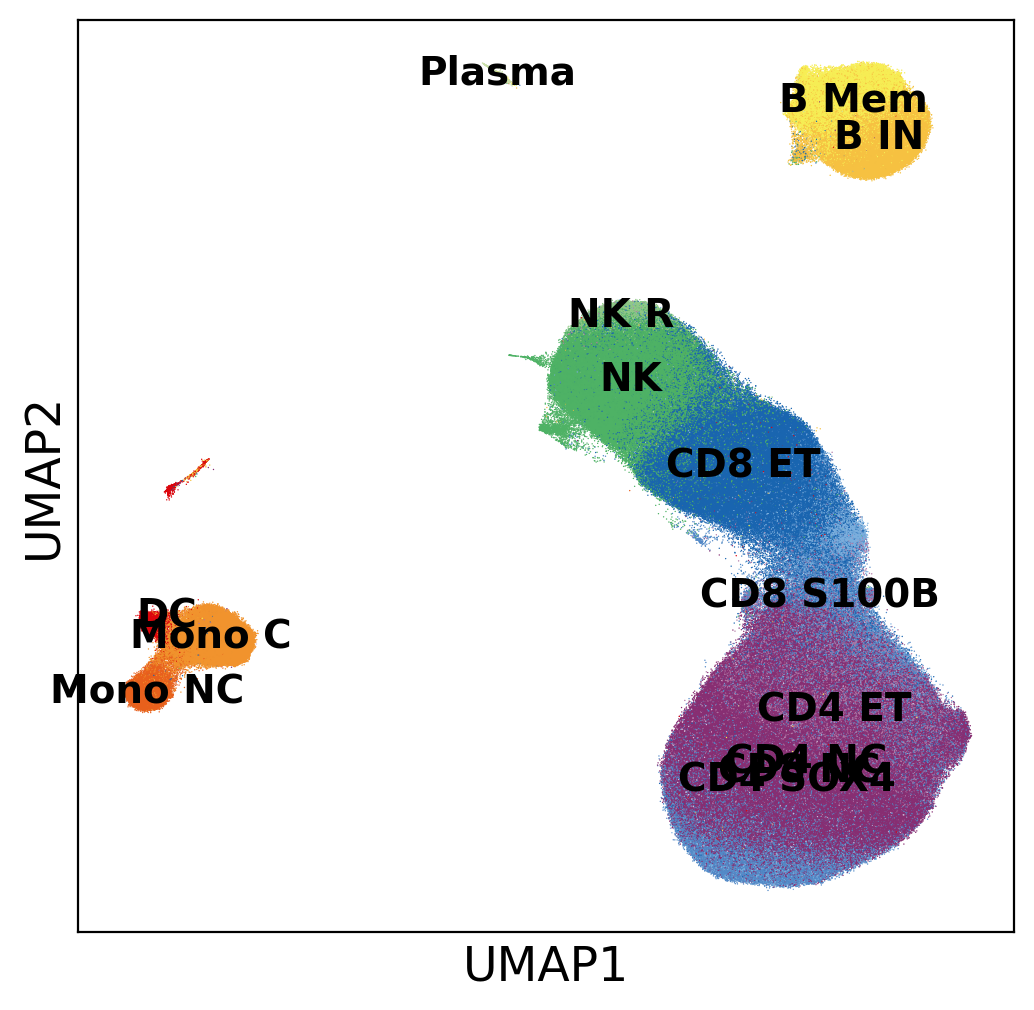

In [491]:
fig, axs = plt.subplots(figsize=(6,6))
sc.pl.umap(adata, color="cell_label", size=1, title="", ax=axs, show=False, legend_loc="on data")
axs.set_xlabel("UMAP1", fontsize=17)
axs.set_ylabel("UMAP2", fontsize=17)
# axs.legend(
#     title="",
#     loc="center left",
#     bbox_to_anchor=(1.03, 0.5),
#     frameon=False,
#     fontsize=14,
#     title_fontsize=16,
#     ncol=4,
#     markerscale=1.3,
#     handletextpad=0.5,
#     columnspacing=1.1,
# )
plt.savefig(os.path.join(model_results_dir, "Figures", f"{model}_UMAP_Cell-state_NEW_legend-on-data.eps"), 
            bbox_inches="tight", transparent=True, dpi=500)
plt.savefig(os.path.join(model_results_dir, "Figures", f"{model}_UMAP_Cell-state_NEW_legend-on-data.png"), 
            bbox_inches="tight", transparent=True, dpi=500)
plt.savefig(os.path.join(model_results_dir, "Figures", f"{model}_UMAP_Cell-state_NEW_legend-on-data.pdf"), 
            bbox_inches="tight", transparent=True, dpi=500)

In [10]:
assignment_matrix = pd.read_csv(
    os.path.join(model_results_dir, f"{model}_factor_assignment_matrix.tsv"),
    sep="\t", index_col=0
)
assignment_matrix

,U_Factor1,U_Factor2,U_Factor3,U_Factor4,U_Factor5,U_Factor6,U_Factor7,U_Factor8,U_Factor9,U_Factor10,...,U_Factor691,U_Factor692,U_Factor693,U_Factor694,U_Factor695,U_Factor696,U_Factor697,U_Factor698,U_Factor699,U_Factor700
Cell-state_Factor1,8.437773e-07,7.903217e-08,0.000149,2.960464e-08,1.052879e-01,9.999727e-01,5.675518e-07,0.958925,2.873756e-04,0.000158,...,5.023212e-06,4.209568e-06,1.000000e+00,4.168299e-03,9.999992e-01,2.091357e-01,7.841858e-02,6.167789e-07,0.018491,1.407721e-01
Cell-state_Factor2,1.292795e-06,6.067657e-08,0.000136,6.915393e-08,1.059085e-01,1.794856e-02,5.106163e-07,0.115423,2.631726e-02,0.000138,...,1.773568e-07,6.894123e-06,7.097198e-02,2.241115e-07,8.517019e-07,4.772369e-02,1.982911e-03,7.762388e-07,0.000035,4.198599e-02
Cell-state_Factor3,9.953613e-07,6.230532e-08,0.000141,1.447328e-06,4.369442e-06,4.638549e-07,9.892867e-01,0.965989,5.854719e-04,0.000156,...,2.023449e-07,2.216382e-06,5.867200e-05,5.172464e-03,6.707507e-07,1.328094e-01,1.249463e-03,1.094831e-06,0.938939,1.547735e-01
Cell-state_Factor4,6.680752e-07,6.124807e-02,0.000136,3.778137e-08,1.143405e-02,4.063994e-07,9.991040e-01,0.019197,8.095721e-03,0.000136,...,2.121831e-07,3.456871e-07,4.101363e-08,3.866343e-07,6.646220e-07,1.024371e-01,1.296003e-02,7.976132e-07,0.000011,3.286937e-02
Cell-state_Factor5,4.728630e-06,2.615931e-08,0.000146,6.789284e-04,1.237816e-01,2.302163e-07,5.004259e-07,1.000000,3.059431e-01,0.000152,...,8.162028e-08,3.348259e-02,3.075602e-08,2.127417e-07,4.462411e-07,8.085923e-02,2.884260e-01,5.094969e-07,0.029717,2.714525e-01
Cell-state_Factor6,9.999322e-01,4.609572e-08,0.000140,5.337527e-08,3.681984e-02,9.848793e-07,4.156005e-06,0.837080,4.801746e-03,0.000154,...,1.835024e-07,5.268766e-08,2.900381e-08,2.648156e-07,4.216614e-07,6.734983e-02,1.485123e-07,9.812329e-01,0.000001,4.904288e-02
Cell-state_Factor7,8.848816e-04,4.144417e-08,0.000171,2.503935e-08,7.618824e-02,3.479813e-07,7.262373e-07,0.258661,3.501588e-01,0.000157,...,1.997454e-07,4.610532e-05,2.670870e-08,9.560621e-01,5.530579e-07,8.596881e-02,1.190066e-05,5.720223e-07,0.000008,8.303037e-02
Cell-state_Factor8,1.136152e-06,1.740751e-07,0.000134,4.542688e-08,5.613364e-02,4.735218e-06,6.645669e-07,0.869501,2.828810e-04,0.000138,...,8.269620e-08,4.141860e-06,3.642555e-07,4.444366e-07,6.135534e-07,6.151829e-03,9.775971e-07,3.348763e-04,0.000008,1.020545e-06
Cell-state_Factor9,9.894364e-01,2.217324e-07,0.000134,8.317852e-08,1.610755e-03,9.816635e-01,6.390773e-07,0.980414,1.310002e-02,0.000141,...,4.868451e-06,2.745850e-06,1.652634e-01,3.112640e-07,7.362058e-01,1.000030e-03,4.295744e-05,2.829697e-07,0.023939,1.960837e-02
Cell-state_Factor10,1.152762e-06,1.184790e-06,0.000140,6.404507e-08,7.889420e-03,2.636182e-07,1.744888e-06,0.941897,2.942594e-04,0.000139,...,9.089991e-08,4.976798e-07,4.306234e-08,2.599173e-07,4.509569e-07,2.611385e-02,2.280514e-07,8.108989e-07,0.015783,6.806477e-03


In [11]:
U = pd.read_csv(os.path.join(model_results_dir,
                            f"{model}_U_embedding.tsv"),
                               sep="\t", index_col=0)
U

,U_Factor1,U_Factor2,U_Factor3,U_Factor4,U_Factor5,U_Factor6,U_Factor7,U_Factor8,U_Factor9,U_Factor10,...,U_Factor691,U_Factor692,U_Factor693,U_Factor694,U_Factor695,U_Factor696,U_Factor697,U_Factor698,U_Factor699,U_Factor700
individual,,,,,,,,,,,,,,,,,,,,,
691_692,-1.042473,-3.014132,1.014801,1.139763,-0.087979,-0.651705,0.490216,-0.437837,-0.698968,-0.075018,...,-1.559727,-2.399024,-0.448335,-0.562907,1.627759,0.417358,-0.134628,0.011702,-0.679321,0.457391
693_694,0.204075,-1.975144,-0.909941,-3.882647,-2.031409,-1.043576,-0.600040,0.700274,-1.798226,1.284830,...,-4.333742,-0.440545,3.113877,-1.716786,-1.533546,0.933507,1.020350,0.339764,-1.053410,0.119764
688_689,-0.265995,-0.624907,-0.622831,-2.176815,0.853737,-0.117719,0.055314,0.302469,0.608836,-1.786304,...,-0.670751,-1.207303,8.913930,-0.353388,-0.325745,-1.125641,0.403694,-0.928585,0.525144,-0.484701
683_684,0.416159,-2.862958,-0.515983,1.572177,0.868042,-0.119366,-0.109651,0.556453,1.886532,-1.681124,...,-2.243293,-1.778274,0.387456,0.630929,-0.590417,0.165828,-2.937147,0.222008,-0.201923,0.057328
684_685,-1.244226,-4.169203,-0.287462,-0.519455,3.750650,-1.336222,0.230874,-0.624908,1.064494,0.636243,...,0.699778,-3.021685,-0.273128,-0.655736,-0.635290,0.228497,1.079147,-1.051518,0.797644,0.003049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
840_841,-0.751418,-5.816171,-0.328341,-1.870143,1.636930,-0.460628,0.469605,1.251108,0.182321,1.833012,...,-0.803448,-0.624590,0.666369,0.859079,0.324981,0.612761,0.448878,2.150842,0.068799,-0.125685
801_802,1.168300,-4.835076,1.361882,-2.070070,-0.261419,-0.654932,-1.345857,1.246695,-0.657730,0.286154,...,-1.582404,-0.452165,3.482999,0.477112,1.236911,-1.420353,0.921176,-0.063443,0.876317,0.504440
797_798,-0.187302,-2.320944,1.052988,-0.537570,-0.598346,-0.889474,0.045391,0.749125,-1.680160,-0.911165,...,0.864292,0.898600,-0.526442,2.037253,-0.172628,0.964238,1.423292,-0.511975,0.483013,-0.211937


In [12]:
GxC_decoder = pd.read_csv(os.path.join(model_results_dir,f"{model}_GxC_decoder.tsv"),
                          sep="\t", index_col=0)
GxC_decoder

,GxC_Factor1,GxC_Factor2,GxC_Factor3,GxC_Factor4,GxC_Factor5,GxC_Factor6,GxC_Factor7,GxC_Factor8,GxC_Factor9,GxC_Factor10,...,GxC_Factor691,GxC_Factor692,GxC_Factor693,GxC_Factor694,GxC_Factor695,GxC_Factor696,GxC_Factor697,GxC_Factor698,GxC_Factor699,GxC_Factor700
Geneid,,,,,,,,,,,,,,,,,,,,,
ENSG00000257019,0.000003,-0.000156,0.000261,-0.000105,0.000109,-0.000148,0.000145,0.000002,0.000106,-0.000083,...,-0.000125,-0.000088,0.000062,-0.000037,-0.000043,-0.000013,-0.000199,-0.000141,0.000042,0.000049
ENSG00000166987,-0.000101,-0.000302,0.000002,-0.000025,0.000096,-0.000122,0.000290,-0.000218,-0.000033,0.000128,...,-0.000093,-0.000059,-0.000712,0.000007,-0.000217,0.000056,0.000027,0.000117,-0.000141,0.000014
ENSG00000170624,-0.000007,-0.000096,-0.000228,0.000753,-0.000033,-0.000042,-0.000032,0.001457,0.000291,-0.000079,...,-0.000690,0.000181,-0.004836,0.000014,-0.000040,0.000021,0.000080,0.000070,-0.000669,-0.000014
ENSG00000140519,0.000013,-0.000071,0.000062,-0.000007,-0.000070,0.000082,-0.000036,0.000126,-0.000059,-0.000021,...,0.000164,0.000251,-0.000099,0.000035,-0.000080,-0.000019,-0.000139,0.000042,-0.000011,-0.000129
ENSG00000117115,-0.000463,-0.000236,0.000113,-0.000527,0.000036,0.000147,-0.000130,-0.000716,-0.000064,0.000002,...,0.000046,0.000210,0.000123,-0.000185,-0.000235,0.000060,-0.000145,0.000712,-0.000128,-0.000025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000185811,-0.000110,0.002336,-0.000056,0.000462,-0.000005,0.000142,0.000071,-0.009100,0.000140,0.000063,...,-0.000346,-0.000582,-0.000197,0.000033,0.000525,0.000056,0.000059,0.000055,-0.000600,-0.000257
ENSG00000234465,-0.000032,0.000183,-0.000025,0.000108,0.000133,0.000220,-0.000154,0.000586,-0.000165,-0.000111,...,-0.000250,0.000015,0.000105,0.000068,0.000117,-0.000131,0.000086,-0.000222,0.000342,-0.000027
ENSG00000170615,0.000065,0.000413,0.000010,0.000060,-0.000052,-0.000140,0.000233,-0.000027,-0.000191,-0.000071,...,0.000147,-0.000052,0.000095,0.000084,-0.000187,0.000040,-0.000055,-0.000071,0.000049,-0.000059


In [13]:
GxC_effects = pd.read_csv(os.path.join(model_results_dir,
                                            f"{os.path.basename(model_results_dir)}_LMM_results_BH-0.05_Ucontext.tsv"),
                               sep="\t")
GxC_effects

,Factor,SNP_id,effect_size,effect_size_se,p_value,assessed_allele,corrected_pvalue
0,U_Factor1,14:81884515,0.128089,0.029964,1.747683e-05,G,3.124271e-02
1,U_Factor5,19:58963530,0.585091,0.071890,1.218412e-16,G,8.928493e-13
2,U_Factor11,6:161111700,1.012741,0.201583,4.265749e-07,C,1.083497e-03
3,U_Factor12,3:39555580,0.505091,0.055674,1.831975e-20,A,1.759641e-16
4,U_Factor14,2:232579379,-0.201663,0.025578,1.112895e-15,G,7.537058e-12
...,...,...,...,...,...,...,...
3989,U_Factor696,6:35402805,2.013616,0.270934,4.697587e-14,C,2.723306e-10
3990,U_Factor698,22:37918472,0.315602,0.064524,8.591598e-07,T,2.062331e-03
3991,U_Factor698,22:38175477,0.298677,0.057110,1.387957e-07,T,3.829152e-04
3992,U_Factor700,2:102957291,-0.758697,0.154228,7.418975e-07,A,1.806789e-03


In [14]:
GxC_effects.SNP_id.nunique()

941